In [1]:
import pandas as pd
import numpy as np
import matplotlib.dates as mdates
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

## Spatial Manipulation
import geopandas as gpd
from shapely.geometry import Point

## Mapping
import folium
from folium import plugins

## Misc
import functools
from itertools import product
import contextily as ctx

pd.options.display.max_columns = None
#pd.options.display.max_rows = None

import matplotlib.colors as mcolors

from mpl_toolkits.axes_grid1 import make_axes_locatable

from sklearn import preprocessing

In [2]:
df = pd.read_csv('pm_no_clean.csv', index_col = 0)

In [3]:
df['pop_difference'] = df['b_Workday Population (excludes tourists) (2014)'] - df['b_Population estimate 2014'] 

In [4]:
atlas = pd.read_csv('/Users/oliverpaul/Data_Science/EDF/to_merge/london_borough_atlas.csv')

In [5]:
atlas = atlas[['Borough', 'b_Population estimate 2014', 'b_Workday Population (excludes tourists) (2014)']]

In [6]:
atlas['pop_difference'] = atlas['b_Workday Population (excludes tourists) (2014)'] - atlas['b_Population estimate 2014']                                                                                                                                                                                 

In [7]:
atlas = atlas.rename(columns={"Borough": "borough"})

In [8]:
#load london borough shape file
fp = "/Users/oliverpaul/Data_Science/EDF/statistical-gis-boundaries-london/ESRI/London_Borough_Excluding_MHW.shp"
map_df = gpd.read_file(fp).to_crs({'init': 'epsg:4326'})
map_df = map_df.rename(columns={"NAME": "borough"})
map_df.sample(3)

borough   GSS_CODE  HECTARES  NONLD_AREA ONS_INNER SUB_2009  \
32        City of London  E09000001   314.942      24.546         T     None   
20                Merton  E09000024  3762.466       0.000         F     None   
0   Kingston upon Thames  E09000021  3726.117       0.000         F     None   

   SUB_2006                                           geometry  
32     None  POLYGON ((-0.11157 51.51075, -0.11159 51.51091...  
20     None  POLYGON ((-0.13432 51.39093, -0.13438 51.39089...  
0      None  POLYGON ((-0.33068 51.32901, -0.33059 51.32909...

In [9]:
borough_map = map_df.to_crs({'init': 'epsg:3857'})

In [10]:
#merging the two datasets together
borough_map = pd.merge(borough_map, atlas, how='left', on='borough')

In [11]:
scaler = preprocessing.StandardScaler()
borough_map['log_pop_difference'] = scaler.fit_transform(borough_map[["pop_difference"]])

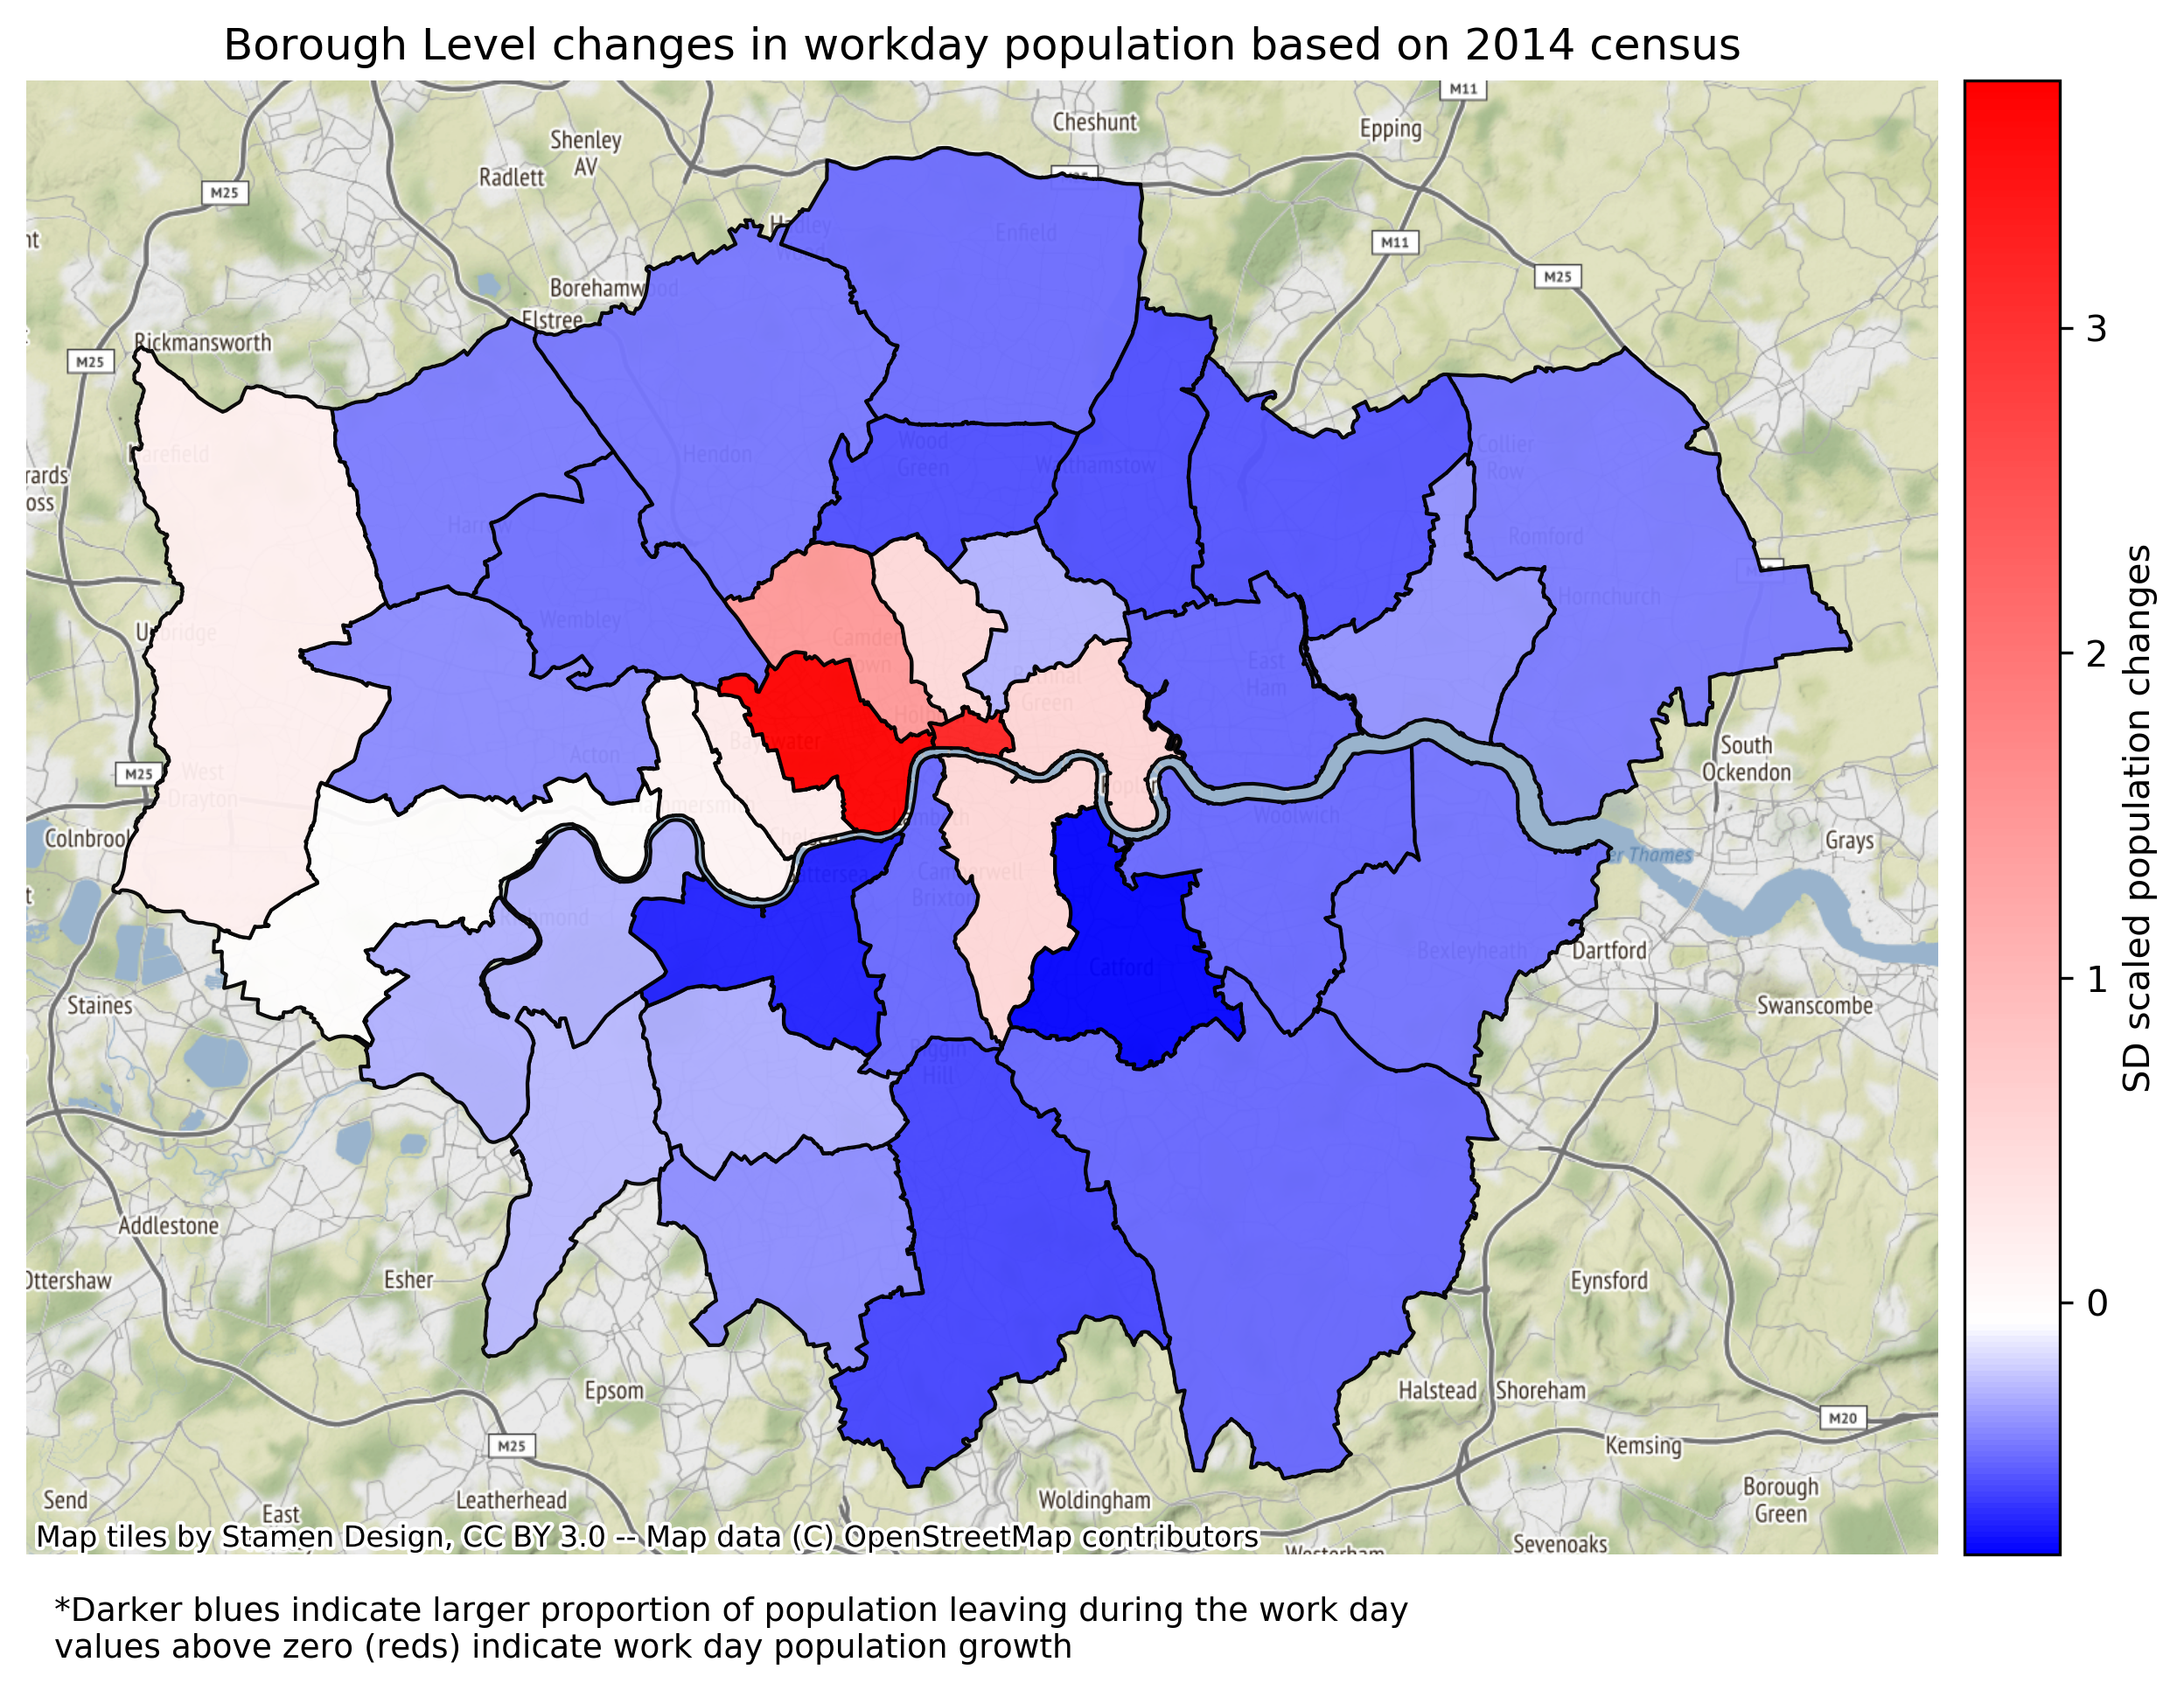

In [12]:
plt.rcParams['figure.dpi'] = 300

fig, ax = plt.subplots(1, 1, figsize=(10, 8))


offset = mcolors.DivergingNorm(vmin=-0.7747735,
                                   vcenter=-0.06, vmax=3.760611)
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.1)

ax = borough_map.plot(figsize=(10, 8), 
                      column='log_pop_difference', 
                      cmap = 'bwr', 
                      edgecolor='k',
                      legend = False,
                      norm=offset,
                      linewidth=1,
                      alpha=0.95,
                      ax=ax) 


cbar = plt.cm.ScalarMappable(norm=offset, cmap='bwr')
ax_cbar = fig.colorbar(cbar, ax=ax, cax=cax)
ax_cbar.set_label('SD scaled population changes')

ax.set_title('Borough Level changes in workday population based on 2014 census', 
                 fontdict={'fontsize': '12', 'fontweight' : '2'})

ctx.add_basemap(ax=ax)

ax.annotate(s= '*Darker blues indicate larger proportion of population leaving during the work day\nvalues above zero (reds) indicate work day population growth', 
            xy=(-60000,6663000), annotation_clip=False, size=9)
ax.axis('off')
plt.show()

Clearly employment and commercial activity in the centre of London is driving daytime migration. As we see from below pollution model, this matches pollution gradient. Could remote working, or employment opportunities outside the centre be a partial solution?

![](pollution.png)

In [13]:
borough_map = borough_map.sort_values(['pop_difference']).reset_index(drop=True)

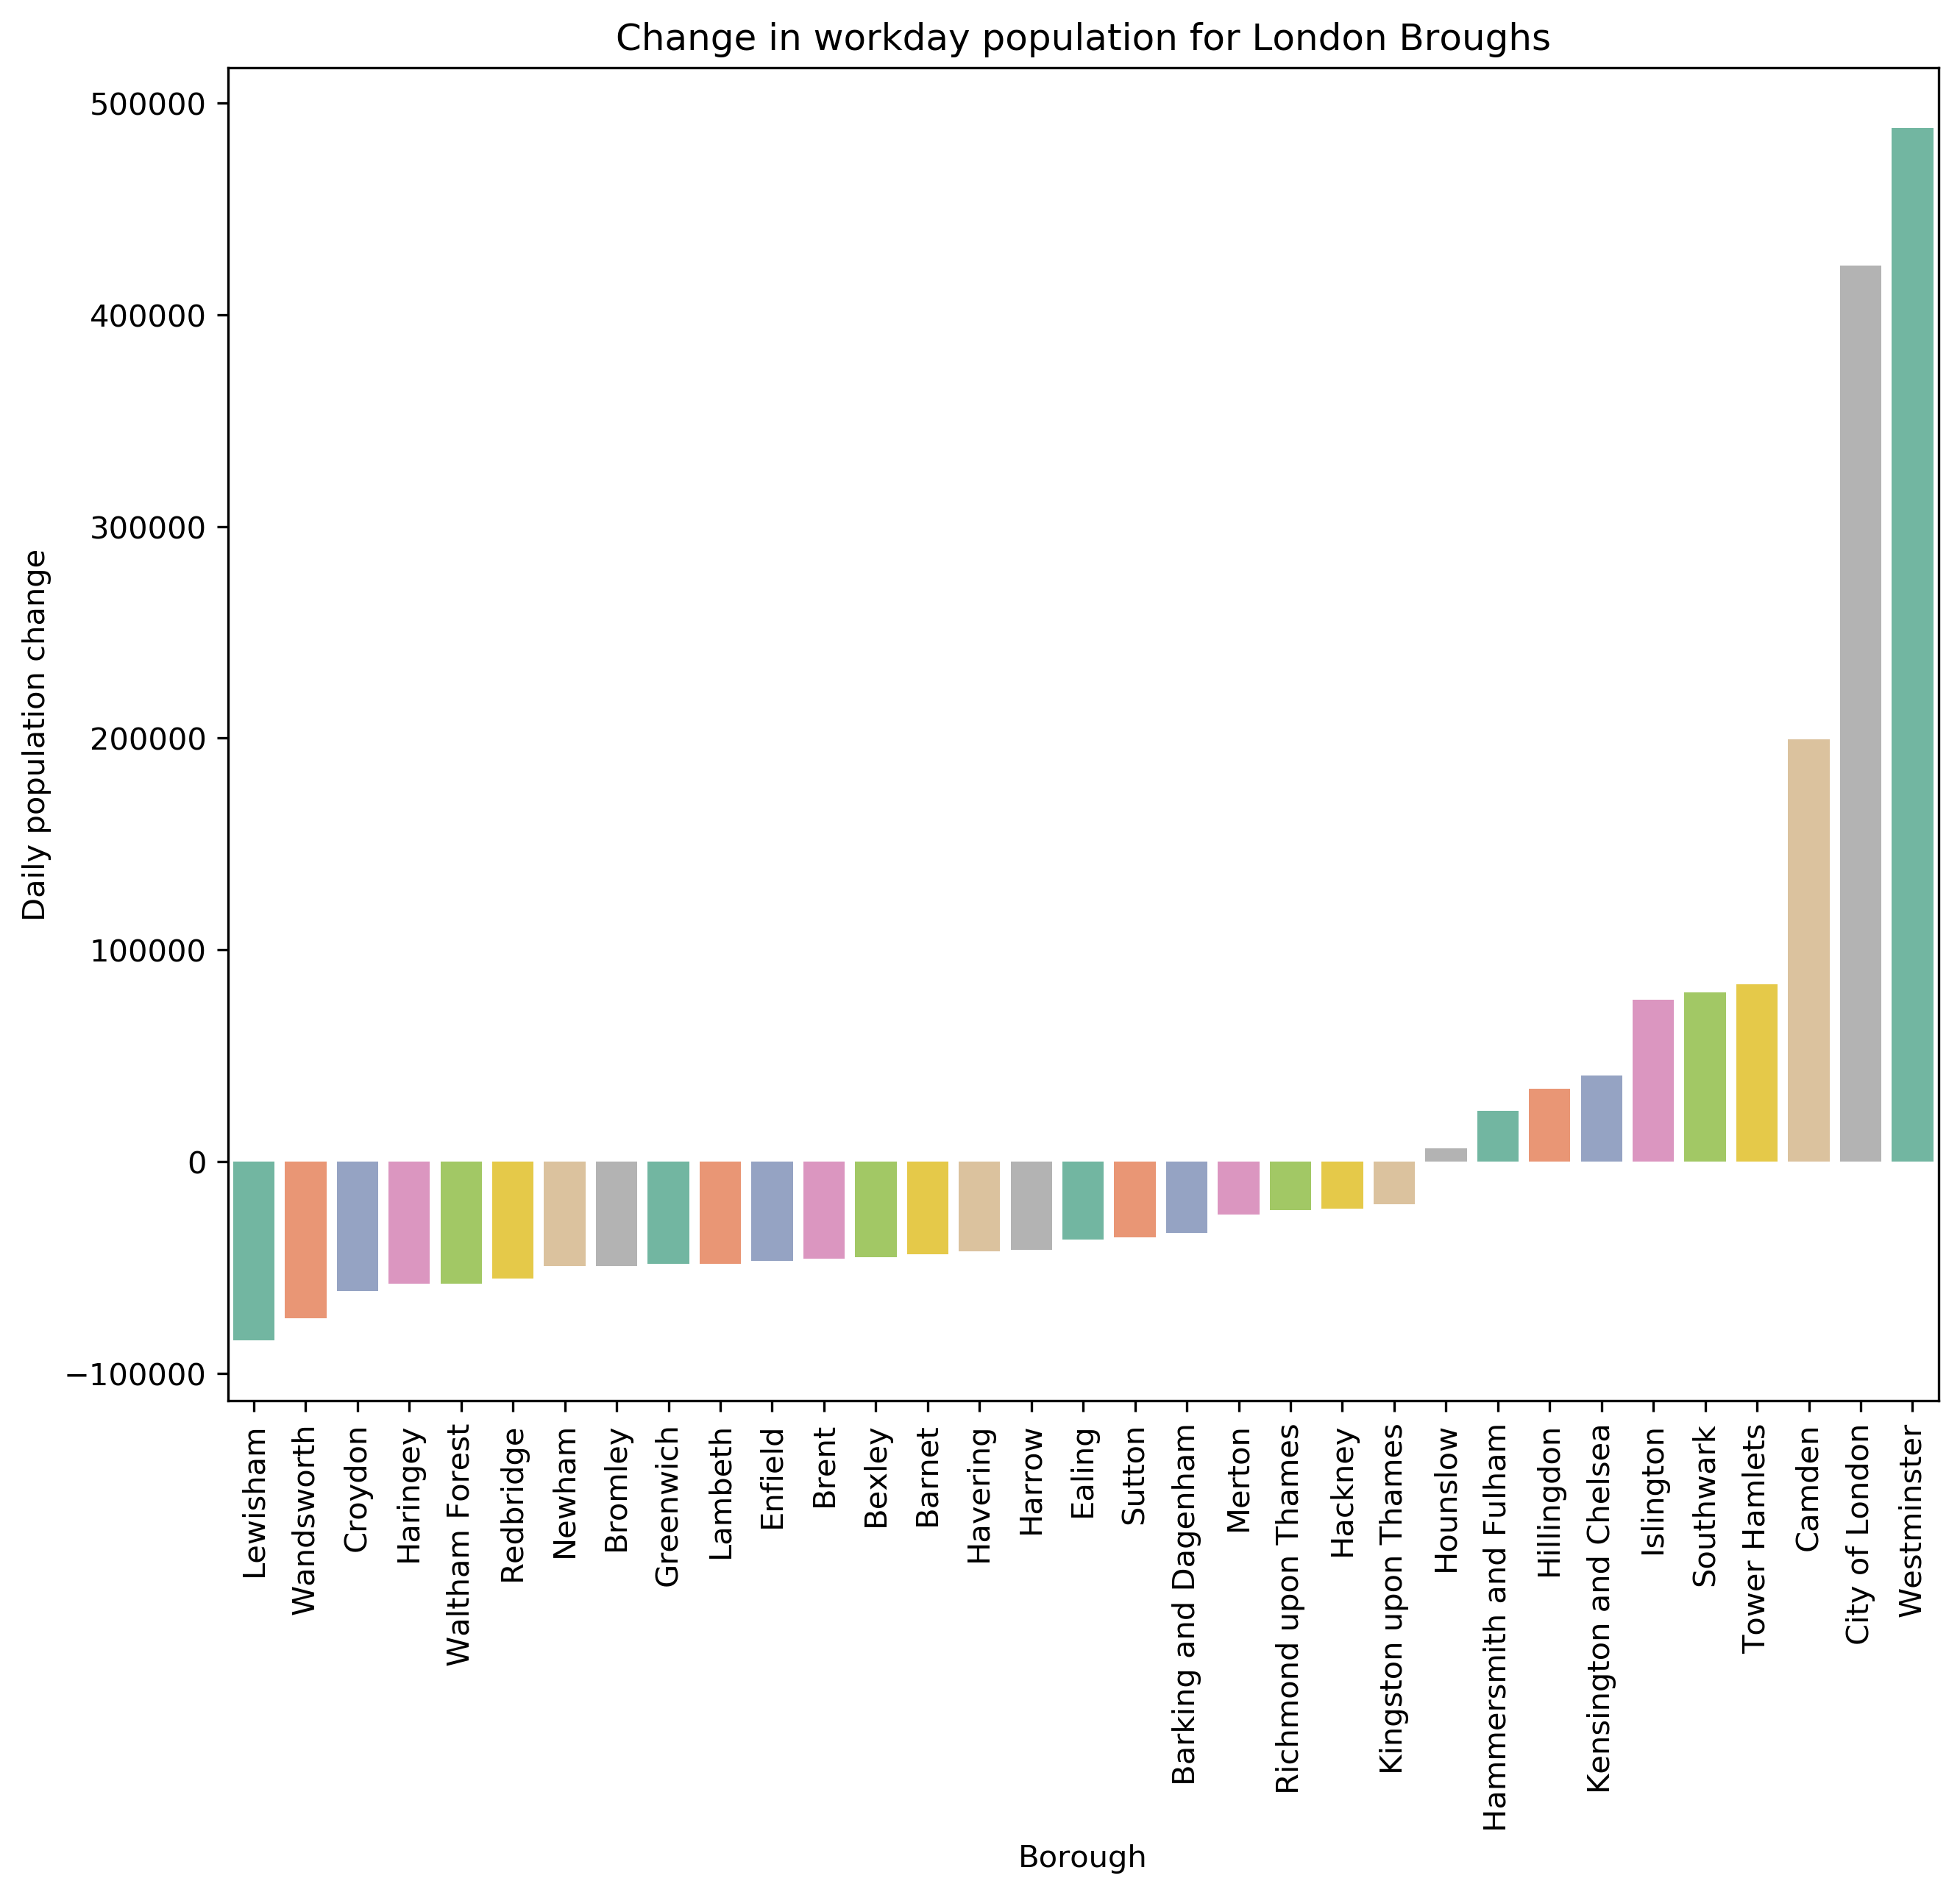

In [14]:
plt.rcParams['figure.dpi'] = 300

fig, ax = plt.subplots(1, 1, figsize=(10, 8))

ax = sns.barplot(x='borough', 
                 y='pop_difference', 
                 data=borough_map,
                palette = 'Set2')

ax.set_xlabel('Borough')
ax.set_ylabel('Daily population change')
ax.set_title('Change in workday population for London Broughs', fontdict={'fontsize': '12', 'fontweight' : '2'})

plt.xticks(rotation=90)
plt.show()